# Cracked Egg Detection

## Handle imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Read image

In [2]:
img_path1 = 'images/test_img1.jpg'
img = cv2.imread(img_path1)

## Declare function to plot each individual egg

In [3]:
# plotting 30 eggs function

def plot30(egg_images, title):
    plt.figure(title)
    for index, egg_img in enumerate(egg_images):
        plt.subplot(3, 10 ,index+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(egg_img, cmap='gray')
        plt.title('{0}'.format(index+1))

## Section 1: Preprocessing

In [4]:
### SECTION 1: PREPROCESSING
# resize for quicker processing 
img_resized = cv2.resize(img, (900, 900))
# rgb version
img_resized_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
# convert to grayscale for processing
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

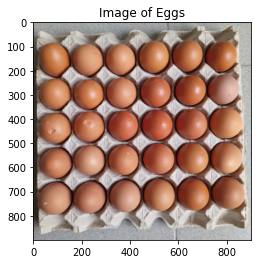

In [5]:
plt.figure()
plt.title('Image of Eggs')
plt.imshow(img_resized_rgb)
plt.show()

## Section 2: Egg Identification From 900x900

In [6]:
### SECTION 2: EGG IDENTIFICATION FROM 900x900
# hough circles
circles = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1, 50, param1=30, param2=40, minRadius=50, maxRadius=70)
detected_circles = np.uint16(np.around(circles))
mask = np.ones_like(img_gray)
mask[True] = 255

egg_images = [] # each single egg image
egg_masks = [] # mask of egg with circle. egg is background due to cv2.circle fill
egg_coords = [] # coordinates of the egg box. to be used for cv2.rectangle in output
for x, y, r in detected_circles[0,:]:
    cv2.circle(mask, (x,y), r, (0,255,0), -1)
    egg_images.append(img_gray[y-r:y+r,x-r:x+r])
    egg_masks.append(mask[y-r:y+r,x-r:x+r])
    # coordinates of the box
    x, y, w, h = x-r, y-r, r*2, r*2
    egg_coords.append((x, y, w, h))

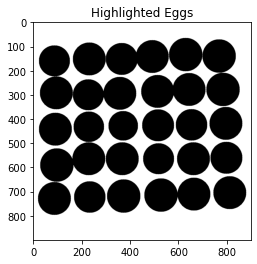

In [7]:
# PLOT: highlighted eggs
plt.figure('highlighted eggs')
plt.title('Highlighted Eggs')
plt.imshow(mask, cmap='gray')
plt.show()

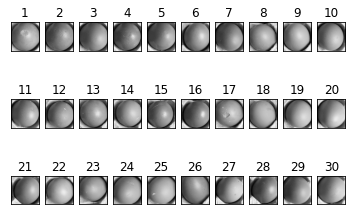

In [8]:
# PLOT: extracted eggs
plot30(egg_images, 'extracted eggs')
plt.show()

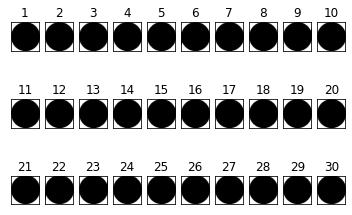

In [9]:
# PLOT: egg masks
plot30(egg_masks, 'egg masks')
plt.show()

## Section 3: Individual Egg Extraction

In [10]:
# SECTION 3: INDIVIDUAL EGG EXTRACTION
# cropping out the egg using the mask
eggs_cropped = []
for egg_img, egg_mask in zip(egg_images, egg_masks):
    # change egg to foreground
    egg_mask = cv2.bitwise_not(egg_mask)
    # erode egg mask to cover guaranteed egg region only
    egg_mask = cv2.erode(egg_mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)), iterations=3)
    # apply mask to the egg
    egg_crop = cv2.bitwise_and(egg_img, egg_mask)

    eggs_cropped.append(egg_crop)

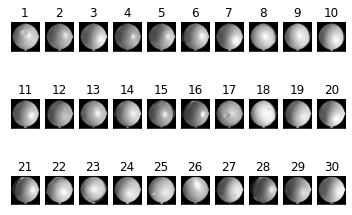

In [11]:
# PLOT: individual cropped eggs
plot30(eggs_cropped, 'cropped eggs')
plt.show()

## Section 4: Abnormality Detection

In [12]:
# SECTION 4: ABNORMALITY DETECTION
def abnormal(egg, style):
    if style == 1:
        # apply canny edge detector to find abnormalities
        egg_abn = cv2.Canny(egg_img, 150, 100)
    elif style == 2:
        # adaptive thres
        egg_abn = cv2.adaptiveThreshold(egg_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 7)
    return egg_abn

egg_abnormals = []
for egg_img, egg_mask in zip(eggs_cropped, egg_masks):
    # use either canny edge or adaptive threshold method to detect abnormalities
    egg_abn = abnormal(egg_img, 1)    

    # change egg to foreground
    egg_mask = cv2.bitwise_not(egg_mask)
    # erode egg mask to cover egg region only
    egg_mask = cv2.erode(egg_mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)), iterations=9)
    # remove outline
    egg_abn = cv2.bitwise_and(egg_abn, egg_mask)

    egg_abnormals.append(egg_abn)

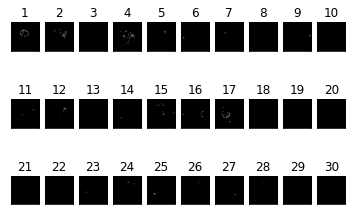

In [13]:
# PLOT: abnormality in eggs
# this is what determines if an egg is cracked or not
plot30(egg_abnormals, 'abnormality eggs')
plt.show()

## Section 5: Classification - Calculate Abnormality Level of Eggs

In [14]:
# SECTION 5: CLASSIFICATION - CALCULATE ABNORMALITY LEVEL OF EGGS
# abnormality correlates to the sum of white pixels
count = []
img_output = img_resized_rgb.copy()
for egg_img, egg_coord in zip(egg_abnormals, egg_coords):
    x, y, w, h = egg_coord
    count.append(np.count_nonzero(egg_img))
    # different count thres for canny and adaptive thres methods
    canny_thres = (70, 20)
    adaptive_thres = (300, 200)
    large_impure, medium_impure = canny_thres # change this depending on canny_thres or adaptive_thres method
    if count[-1] > large_impure:
        # print("large impurity")
        cv2.rectangle(img_output, (x,y),(x+w,y+h), (255,0,0), 3)
    elif count[-1] > medium_impure:
        # print("medium impurity")
        cv2.rectangle(img_output, (x,y),(x+w,y+h), (255,255,0), 3)

Plot: Ordered Count of Abnormalities

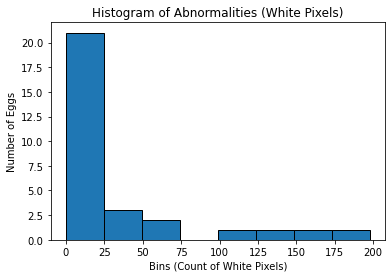

In [15]:
# PLOT: COUNT OF ABNORMALITIES
plt.figure('count')
plt.hist(count, bins=8, edgecolor='black')
plt.title('Histogram of Abnormalities (White Pixels)')
plt.ylabel('Number of Eggs')
plt.xlabel('Bins (Count of White Pixels)')
plt.show()

## Output: Cracked Eggs Isolated in Rectangles

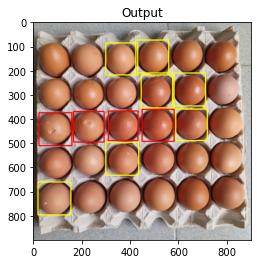

In [16]:
plt.figure('output')
plt.title('Output')
plt.imshow(img_output)
plt.show()